In [1]:
%load_ext autoreload
%autoreload 2

# imports


In [2]:
import numpy as np
import pandas as pd
import warnings
import seaborn as sns
import pickle
from matplotlib.colors import LogNorm
from matplotlib.gridspec import GridSpec
from scipy.optimize import fmin_l_bfgs_b
from scipy.special import erfinv
from scipy.stats import chi2

from fluxes import atmo_background
from fluxes import astro_flux
from settings import ngc1068
from tools import get_mids
from scipy.interpolate import RegularGridInterpolator


matplotlib = sns.mpl
plt = matplotlib.pyplot
plt.style.use("../style.mplstyle")
warnings.filterwarnings("ignore")

Could not import healpy.
functions plot_area, add_catalog, and add_extended_plane will not work.


# loading effective areas


In [3]:
sindec_bins, logE_bins, aeffs = pd.read_pickle("../resources/aeff_cluster_nuecc_with-eq.pickle")


## binning

In [4]:
aeff_test = aeffs.iloc[0]["equatorial"] # for testing
logE_mids = get_mids(logE_bins)
ebins = np.power(10, logE_bins)
emids = get_mids(ebins)
ewidth = np.diff(ebins)
sindec_mids = get_mids(sindec_bins)
sindec_width = np.diff(sindec_bins)

print(len(emids), "log_10(energy) bins")
print(len(sindec_mids), "declination bins")

40 log_10(energy) bins
39 declination bins


# background

In [5]:
# MCEQ
with open("../resources/MCEq_flux.pckl", "rb") as f:
    (e_grid, zen), flux_def = pickle.load(f)
# load total nue+nuebar + nutau+nutaubar
# (nutau+nutaubar is practically zero)
rgi = RegularGridInterpolator(
    (e_grid, -np.cos(np.deg2rad(zen))), np.log(flux_def["nue_total"] + flux_def["nutau_pr"])
)
ee, ss = np.meshgrid(emids, sindec_mids)
spl_vals = np.exp(rgi((ee, ss)))

# astro flux source parameters

In [13]:
# livetime of 10yr in seconds
LIVETIME = 365 * 10 * 24 * 3600
# diffuse flux
from aeff_calculations import aeff_eval_e_sd
from settings import E_NORM, PHI_ASTRO, GAMMA_ASTRO
PHI_ASTRO *= 2

print(PHI_ASTRO)
print(GAMMA_ASTRO)


2.88e-18
2.37


## calculate number of events for diffuse flux

In [14]:
n_events = pd.read_pickle("../resources/casc_events_diffuse.pickle")

In [15]:
n_events = []
for ind, row in aeffs.iterrows():
    dct = {}
    for nm, val in zip(aeffs.index.names, ind):
        dct[nm] = val
    aeff_factor = (
        (row["equatorial"] * sindec_width).T * ewidth * 2*np.pi * LIVETIME
    )
    k_s = astro_flux(
        "powerlaw",
        aeff_factor,
        emids,
        E_NORM,
        GAMMA_ASTRO,
        1,
        phi_0=PHI_ASTRO,
    )
    dct["n_sig"] = np.sum(k_s)

    k_b = atmo_background(
        aeff_factor,
        spl_vals,
    )
    dct["n_bg"] = np.sum(k_b)
    dct["s/sqb"] = dct["n_sig"] / np.sqrt(dct["n_bg"])
    n_events.append(dct)
n_events = pd.DataFrame(n_events)

pd.to_pickle(n_events, "../resources/casc_events_diffuse.pickle")


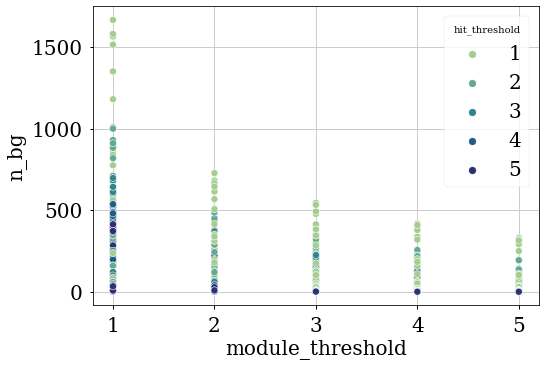

In [16]:
ax = sns.scatterplot(
    data=n_events, x="module_threshold", y="n_bg", hue="hit_threshold", palette="crest"
)


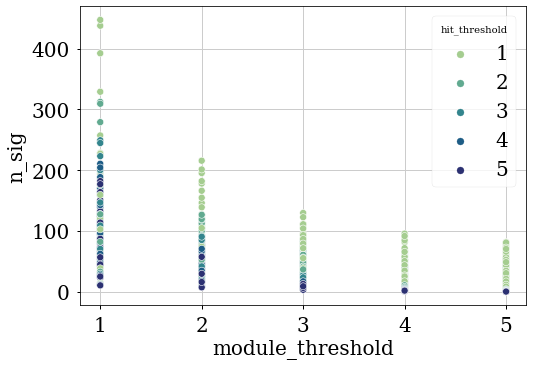

In [17]:
ax = sns.scatterplot(
    data=n_events, 
    x="module_threshold",
    y="n_sig",
    hue="hit_threshold",
    palette="crest",
)


# simple diffuse fit

## energy and sindec resolution

In [18]:
resolution_df = pd.read_pickle("../resources/optimization_resolutions.pickle")
resolution_df = resolution_df.set_index(["config", "spacing", "pmts"])


## llh definition

In [19]:
def ps_llh_2d_composite(
    x,
    mu_b_base,
    mu_s_base,
    k_i,
    e_0,
    phi_0,
    shape,
    normed_kvals,
    plot_this=False
):
    """fit parameters in x:
    for the standard power law:
    x[0]: background normalization scaling
    x[1]: signal spectral index
    x[2]: signal normalization scaling

    see 'astro_flux' for further shapes and parameters

    mu_b_base: effective area factor
    mu_s_base: effective area factor for signal
    k_i: observation/asimov data
    e_norm: normalization energy, default E0_NGC
    phi_0: normalization flux, default PHI_NGC
    shape: flux shape, default 'powerlaw'
    """

    mu_b = atmo_background(
        mu_b_base * x[0],
        spl_vals,
        normed_kvals=normed_kvals,
    )
    mu_s = astro_flux(
        shape, mu_s_base, emids, e_0, *x[1:], phi_0=phi_0, normed_kvals=normed_kvals
    )
    mu_i = mu_s + mu_b
    if plot_this:
        f, axes = plt.subplots(ncols=2, figsize=(12,6))
        axes[0].plot(np.log10(emids), mu_s.sum(axis=0), ls="-", label="mu_s", ds="steps-mid")
        axes[0].plot(np.log10(emids), mu_b.sum(axis=0), ls="--", label="mu_b", ds="steps-mid")
        axes[0].set_yscale("log")
        axes[0].legend()
        
        sdm = np.linspace(-1, 1, 39)
        axes[1].plot(sdm, mu_s.sum(axis=1), ls="-", label="mu_s", ds="steps-mid")
        axes[1].plot(sdm, mu_b.sum(axis=1), ls="--", label="mu_b", ds="steps-mid")
    return -2 * np.sum(
        np.where(
            np.logical_and(mu_i > 0, k_i > 0),
            k_i * np.log(mu_i)
            - mu_i
            - 0.5 * np.log(2 * np.pi * k_i)
            + k_i
            - k_i * np.log(k_i),
            0,
        )
    )


# diffuse vs uniform atmospheric

## check

out comb (array([1.  , 2.37, 1.  ]), 2645.556599606216, {'grad': array([0., 0., 0.]), 'task': 'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL', 'funcalls': 4, 'nit': 0, 'warnflag': 0})
out bg (array([1.1414805]), 2658.076425437615, {'grad': array([4.54747354e-05]), 'task': 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH', 'funcalls': 16, 'nit': 5, 'warnflag': 0})
(1, 1, nan, 200.0)



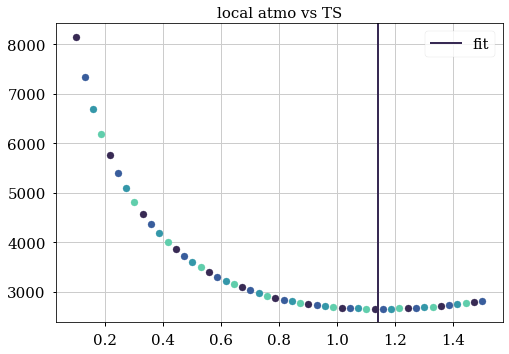

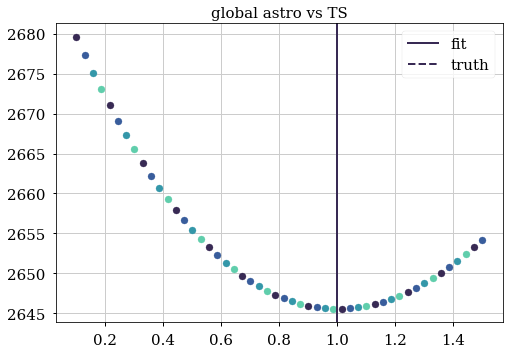

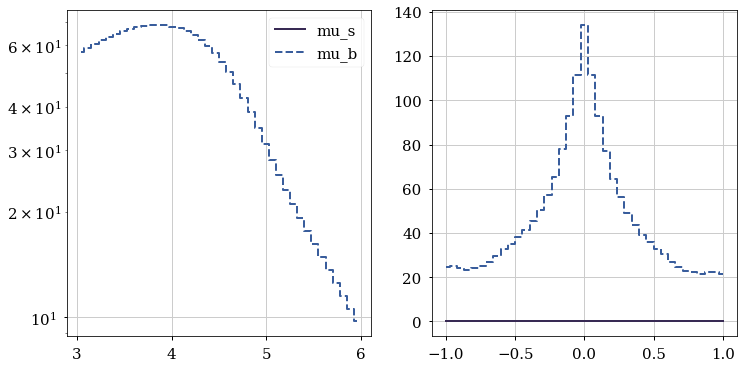

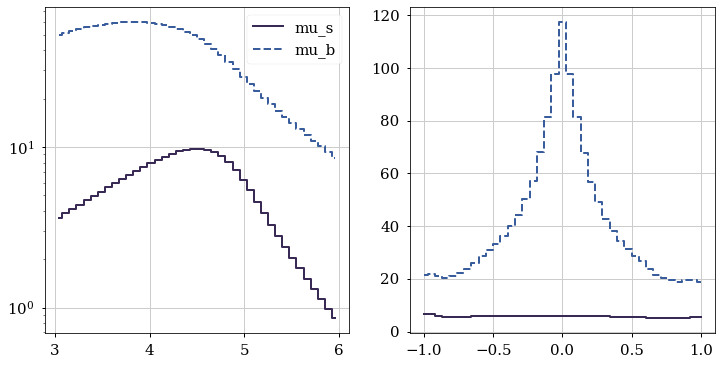

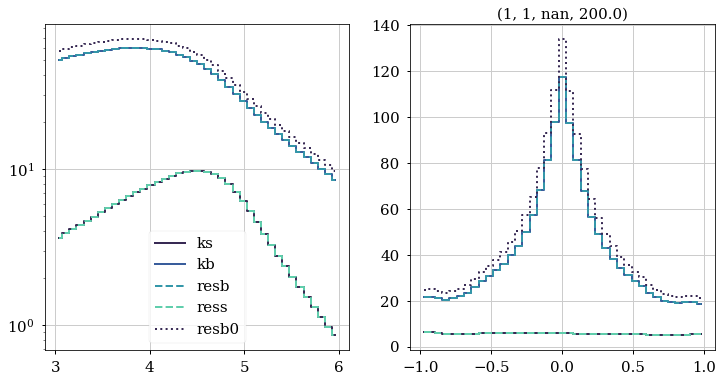

out comb (array([1.  , 2.37, 1.  ]), 1824.734353265424, {'grad': array([0., 0., 0.]), 'task': 'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL', 'funcalls': 4, 'nit': 0, 'warnflag': 0})
out bg (array([1.16999051]), 1835.9644813764908, {'grad': array([0.00013642]), 'task': 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH', 'funcalls': 16, 'nit': 5, 'warnflag': 0})
(2, 1, nan, 200.0)



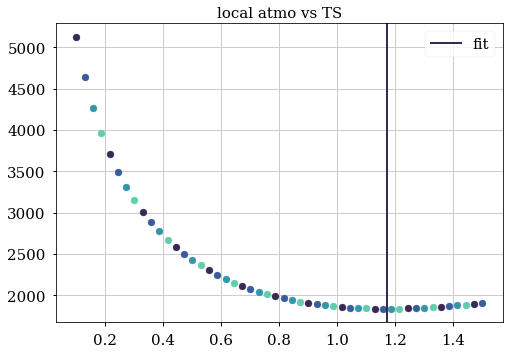

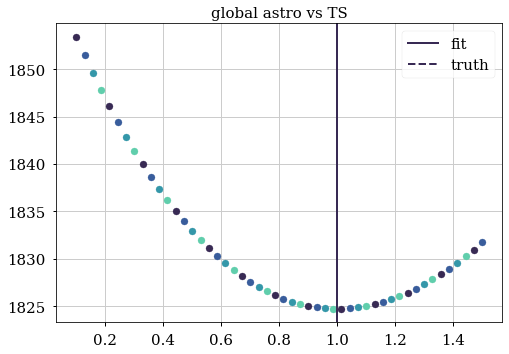

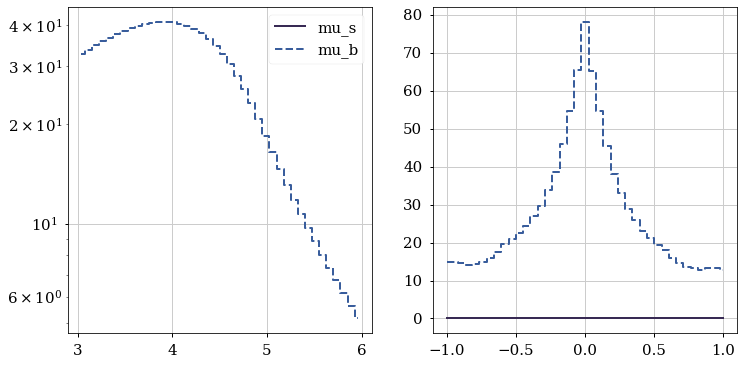

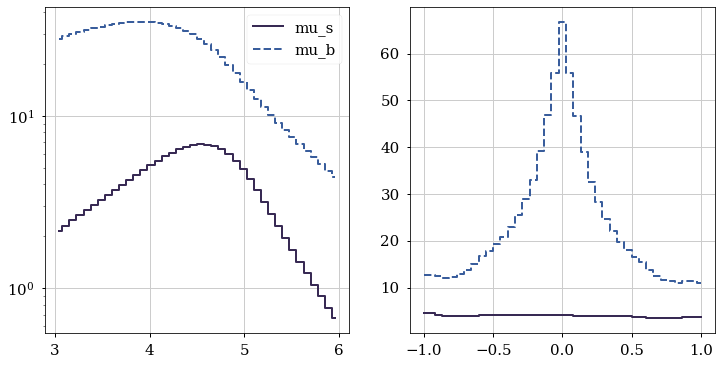

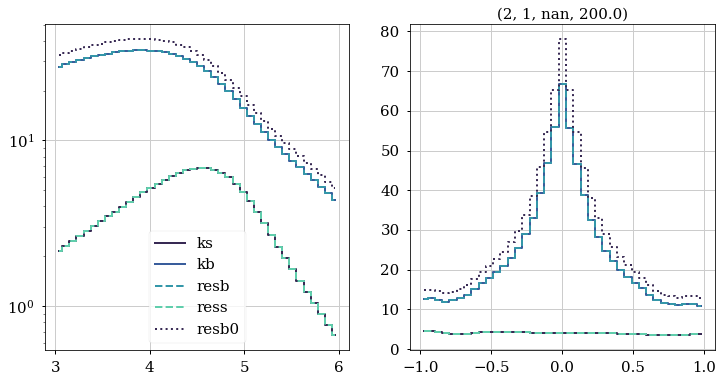

out comb (array([1.  , 2.37, 1.  ]), 1316.811475786241, {'grad': array([0., 0., 0.]), 'task': 'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL', 'funcalls': 4, 'nit': 0, 'warnflag': 0})
out bg (array([1.19039261]), 1327.3424821699227, {'grad': array([4.54747354e-05]), 'task': 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH', 'funcalls': 18, 'nit': 6, 'warnflag': 0})
(3, 1, nan, 200.0)



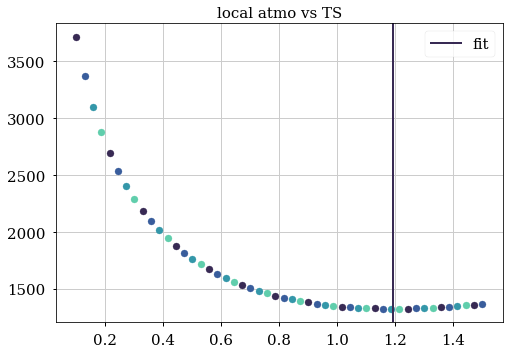

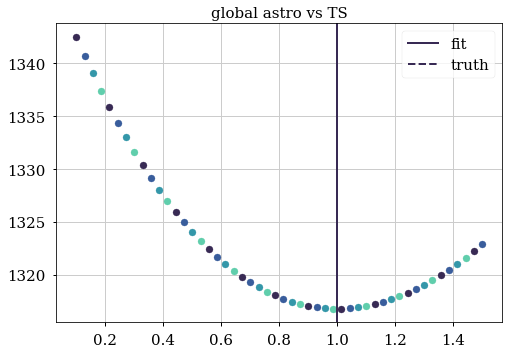

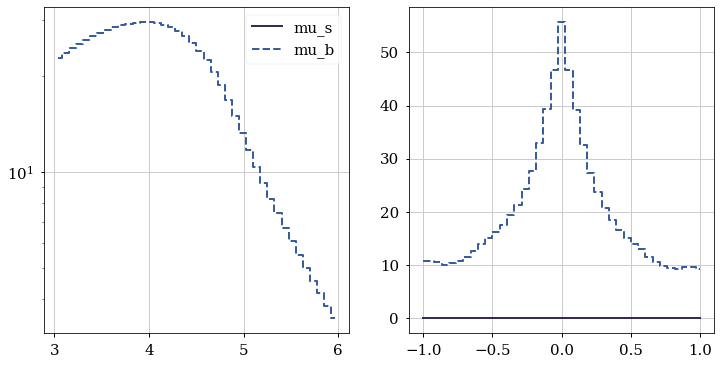

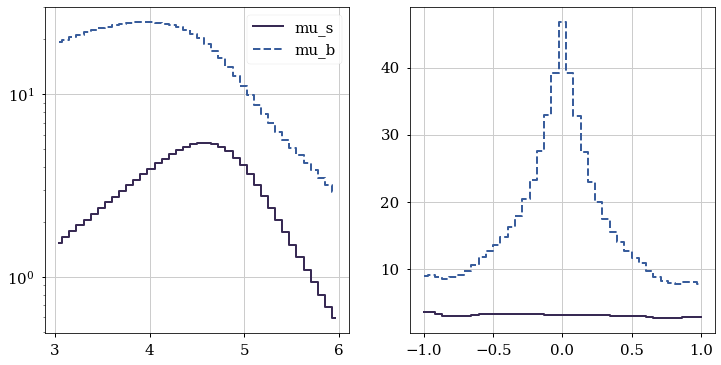

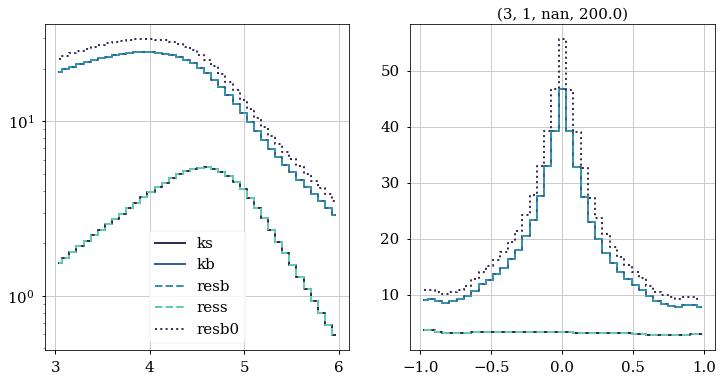

out comb (array([1.  , 2.37, 1.  ]), 892.0069826812231, {'grad': array([0., 0., 0.]), 'task': 'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL', 'funcalls': 4, 'nit': 0, 'warnflag': 0})
out bg (array([1.21292779]), 902.3656469023567, {'grad': array([0.]), 'task': 'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL', 'funcalls': 18, 'nit': 6, 'warnflag': 0})
(4, 1, nan, 200.0)



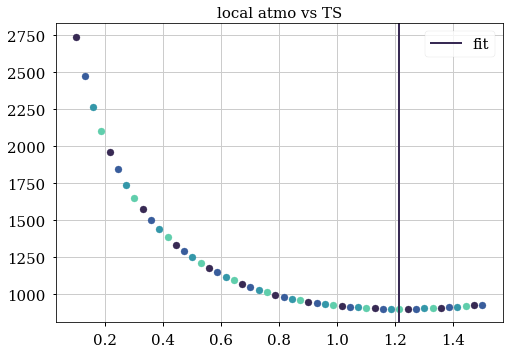

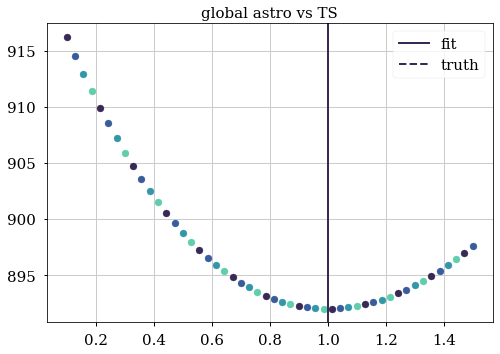

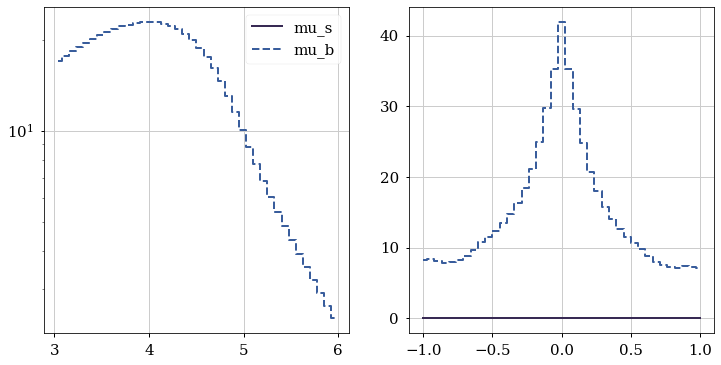

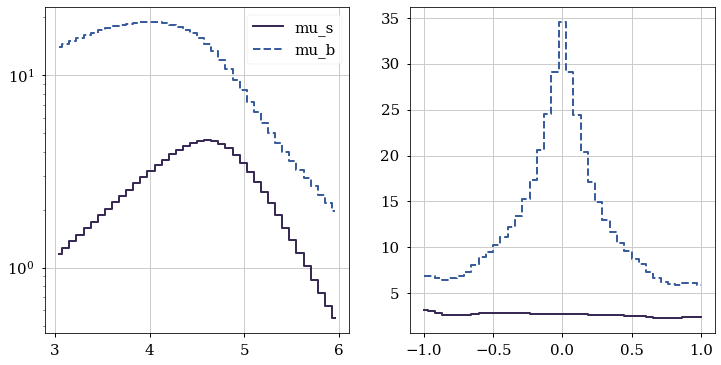

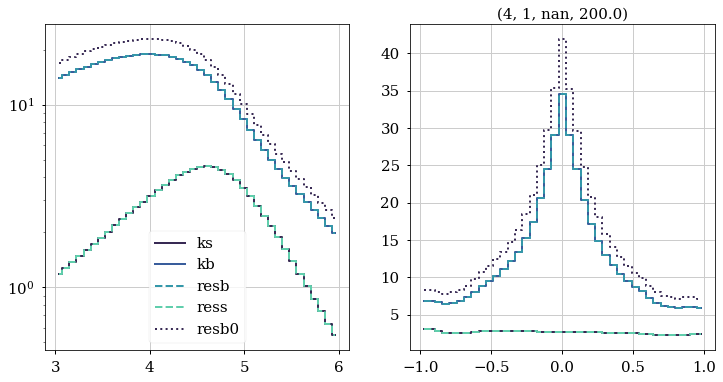

out comb (array([1.  , 2.37, 1.  ]), 527.28912856772, {'grad': array([0., 0., 0.]), 'task': 'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL', 'funcalls': 4, 'nit': 0, 'warnflag': 0})
out bg (array([1.23779729]), 537.7525783154377, {'grad': array([-1.13686838e-05]), 'task': 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH', 'funcalls': 18, 'nit': 6, 'warnflag': 0})
(5, 1, nan, 200.0)



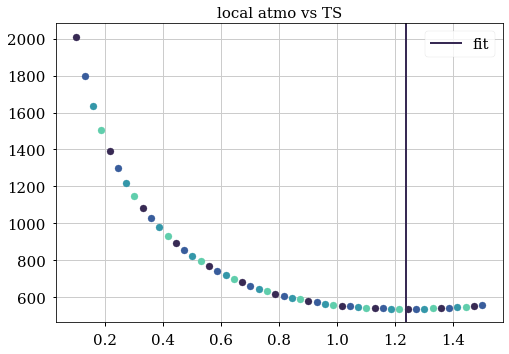

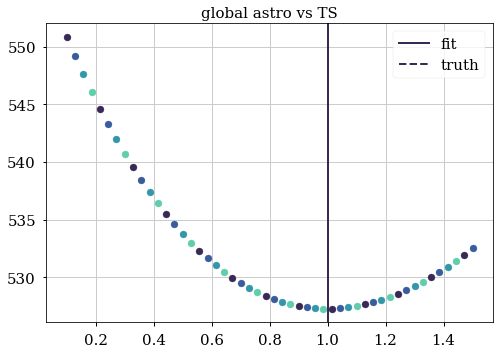

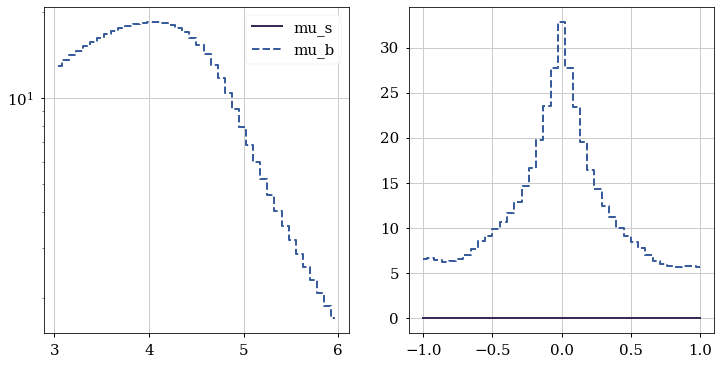

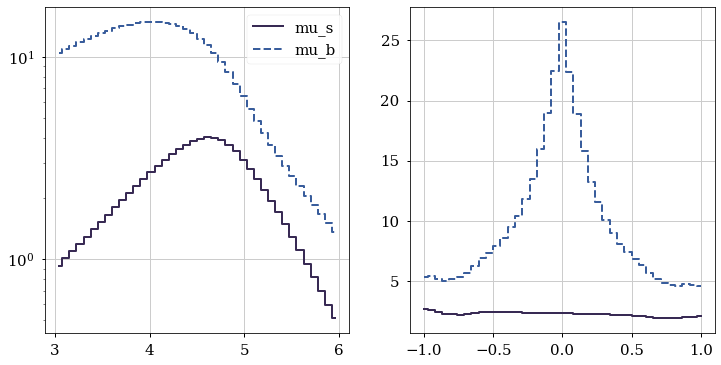

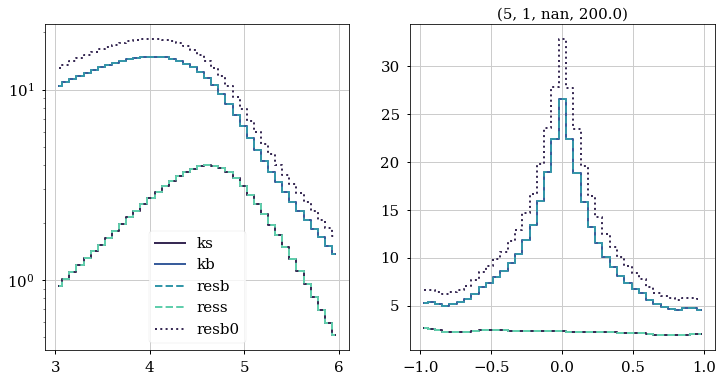

out comb (array([1.  , 2.37, 1.  ]), 422.0078361095782, {'grad': array([1.13686838e-05, 1.13686838e-05, 5.68434192e-06]), 'task': 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH', 'funcalls': 24, 'nit': 1, 'warnflag': 0})
out bg (array([1.31840069]), 439.0713047766719, {'grad': array([0.]), 'task': 'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL', 'funcalls': 16, 'nit': 4, 'warnflag': 0})
(1, 2, nan, 200.0)



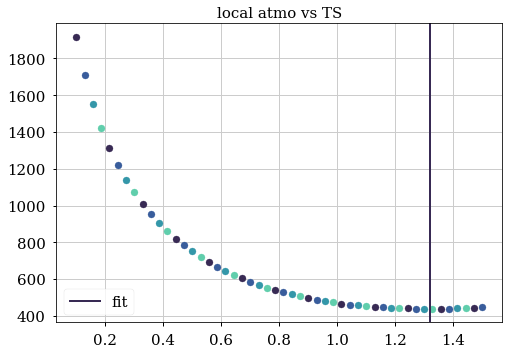

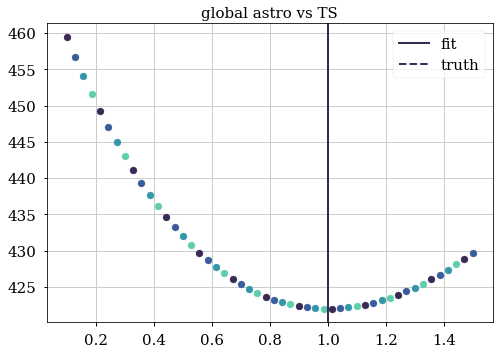

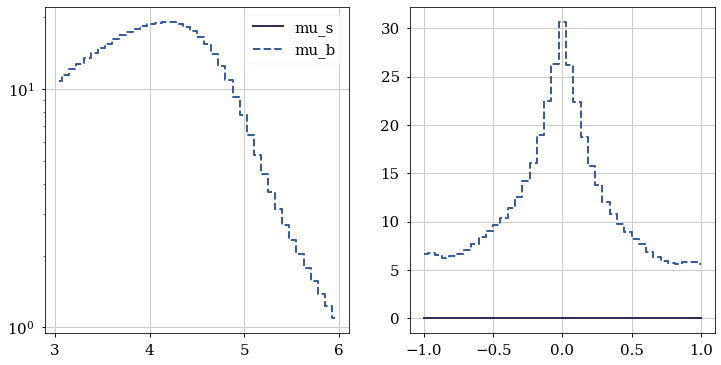

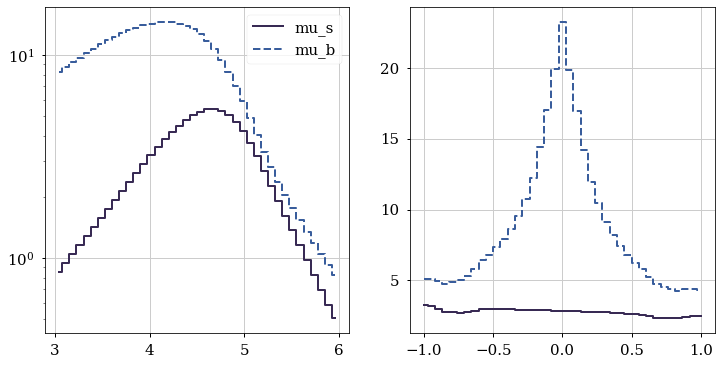

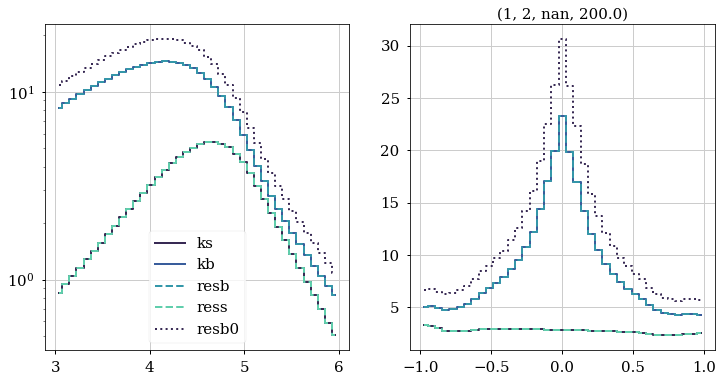

In [135]:
c_names = np.asarray(aeffs.index.names)
mask = aeffs.index.get_level_values("spacing") >= 50

atmo_range = np.linspace(0.1, 1.5, num=50)
astro_range = np.linspace(0.1, 1.5, num=50)
gamma_range = np.linspace(1, 4, num=20)

full_det = False
diff_significances = []
for config, aeff in aeffs.loc[mask].iterrows():
    if full_det:
        aeff *= 7  # full detector
    tmp = {key: val for key, val in zip(c_names, config)}
    aeff_test = aeff["equatorial"]
    reso_test = resolution_df.loc["Full pessimistic cluster", config[-1], 16]

    aeff_factor = (aeff_test * sindec_width).T * ewidth * 2 * np.pi * LIVETIME
    k_s = astro_flux(
        "powerlaw",
        np.copy(aeff_factor),
        emids,
        E_NORM,
        GAMMA_ASTRO,
        1,
        phi_0=PHI_ASTRO,
        normed_kvals=reso_test.energy_res,
    )

    k_b = atmo_background(
        np.copy(aeff_factor),
        spl_vals,
        normed_kvals=reso_test.energy_res,
    )

    k_i = k_s + k_b

    tmp["nb"] = np.sum(k_b)
    tmp["ns"] = np.sum(k_s)

    # fix signal contribution to 0
    fit_config = dict(
        mu_b_base=np.copy(aeff_factor),
        mu_s_base=np.copy(aeff_factor),
        k_i=k_i,
        e_0=E_NORM,
        phi_0=PHI_ASTRO,
        shape="powerlaw",
        normed_kvals=reso_test.energy_res,
    )
    local_llh = lambda x: ps_llh_2d_composite((x[0], 3, 0), **fit_config)
    global_llh = lambda x: ps_llh_2d_composite(x, **fit_config)
    out_bckg = fmin_l_bfgs_b(
        local_llh,
        x0=(1,),
        bounds=[(1e-3, 1e2)],
        approx_grad=True,
    )
    tmp["bg_atmo_norm"] = out_bckg[0][0]

    out_comp = fmin_l_bfgs_b(
        global_llh,
        x0=(1, GAMMA_ASTRO, 1),
        bounds=[(1e-3, 1e2), (2.0, 3.0), (1e-3, 1e2)],
        approx_grad=True,
        factr=10,
    )
    tmp["status"] = out_comp[2]["warnflag"]
    tmp["comb_atmo_norm"] = out_comp[0][0]
    tmp["comb_astro_gamma"] = out_comp[0][1]
    tmp["comb_astro_norm"] = out_comp[0][2]
    tmp["-2DLLH"] = out_bckg[1] - out_comp[1]
    tmp["bg_TS"] = out_bckg[1]
    tmp["comb_TS"] = out_comp[1]
    tmp["check_TS"] = global_llh((1, GAMMA_ASTRO, 1))

    pval = chi2.sf(out_bckg[1] - out_comp[1], 2)
    significance = erfinv(1 - pval) * np.sqrt(2)
    tmp["pval"] = pval
    tmp["sigma"] = significance
    tmp["check_sigma"] = erfinv(
        1 - chi2.sf(out_bckg[1] - tmp["check_TS"], 2)
    ) * np.sqrt(2)
    diff_significances.append(tmp)

    # if tmp["check_sigma"] == 0: # or abs(tmp["check_TS"] - tmp["comb_TS"]) > 1:
    # if abs(tmp["check_TS"] - tmp["comb_TS"]) > 1:
    if (tmp["spacing"] == 200) and (tmp["ns"] > 70):
        print("out comb", out_comp)
        print("out bg", out_bckg)
        plt.figure()
        plt.title("local atmo vs TS")
        for ar in atmo_range:
            check_bg = local_llh((ar,))
            plt.scatter(ar, check_bg)
        plt.axvline(tmp["bg_atmo_norm"], label="fit")
        plt.legend()
        plt.figure()
        plt.title("global astro vs TS")
        for ar in astro_range:
            check = global_llh((1, GAMMA_ASTRO, ar))
            plt.scatter(ar, check)
        plt.axvline(tmp["comb_astro_norm"], label="fit")
        plt.axvline(1, label="truth", ls="--")
        plt.legend()
        ps_llh_2d_composite((tmp["bg_atmo_norm"], 3, 0), **fit_config, plot_this=True)
        ps_llh_2d_composite(out_comp[0], **fit_config, plot_this=True)
        res_s = astro_flux(
            "powerlaw",
            aeff_factor,
            emids,
            E_NORM,
            tmp["comb_astro_gamma"],
            tmp["comb_astro_norm"],
            phi_0=PHI_ASTRO,
            normed_kvals=reso_test.energy_res,
        )
        res_b = k_b * tmp["comb_atmo_norm"]
        res_b_0 = k_b * tmp["bg_atmo_norm"]
        print(config)
        # print("comb output", out_comp[0], out_comp[1])
        f, axes = plt.subplots(ncols=2, figsize=(12, 6))
        axes[0].plot(logE_mids, k_s.sum(axis=0), ls="-", label="ks", ds="steps-mid")
        axes[0].plot(logE_mids, k_b.sum(axis=0), ls="-", label="kb", ds="steps-mid")
        axes[0].plot(
            logE_mids, res_b.sum(axis=0), ls="--", label="resb", ds="steps-mid"
        )
        axes[0].plot(
            logE_mids, res_s.sum(axis=0), ls="--", label="ress", ds="steps-mid"
        )
        axes[0].plot(
            logE_mids, res_b_0.sum(axis=0), ls=":", label="resb0", ds="steps-mid"
        )
        axes[0].set_yscale("log")
        axes[0].legend()

        axes[1].plot(sindec_mids, k_s.sum(axis=1), ls="-", label="ks", ds="steps-mid")
        axes[1].plot(sindec_mids, k_b.sum(axis=1), ls="-", label="kb", ds="steps-mid")
        axes[1].plot(
            sindec_mids, res_b.sum(axis=1), ls="--", label="resb", ds="steps-mid"
        )
        axes[1].plot(
            sindec_mids, res_s.sum(axis=1), ls="--", label="ress", ds="steps-mid"
        )
        axes[1].plot(
            sindec_mids, res_b_0.sum(axis=1), ls=":", label="resb0", ds="steps-mid"
        )
        plt.title(config)
        print("")
        plt.show()
        # raise BaseException(">:O")


diff_significances = pd.DataFrame(diff_significances)
diff_significances["comb_threshold"] = np.asarray(
    diff_significances.hit_threshold + diff_significances.module_threshold * 10,
    dtype=int,
)

diff_significances["sigma_cut"] = 7
diff_significances.loc[
    diff_significances["sigma"] <= 7, "sigma_cut"
] = diff_significances.loc[diff_significances["sigma"] <= 7, "sigma"]


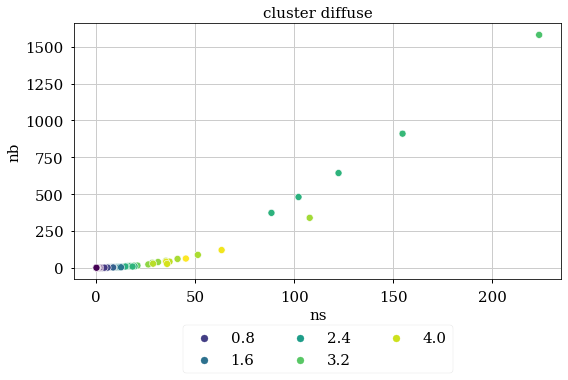

In [138]:
selection = diff_significances.loc[(diff_significances.ns >= 0) & (diff_significances.spacing==200)]
ax = sns.scatterplot(
    data=selection,
    x="ns",
    hue="sigma",
    y="nb",
    palette="viridis",
)
ax.legend(ncol=3, loc="upper center", bbox_to_anchor=(0.5, -0.15))
plt.title("cluster diffuse")
plt.tight_layout()


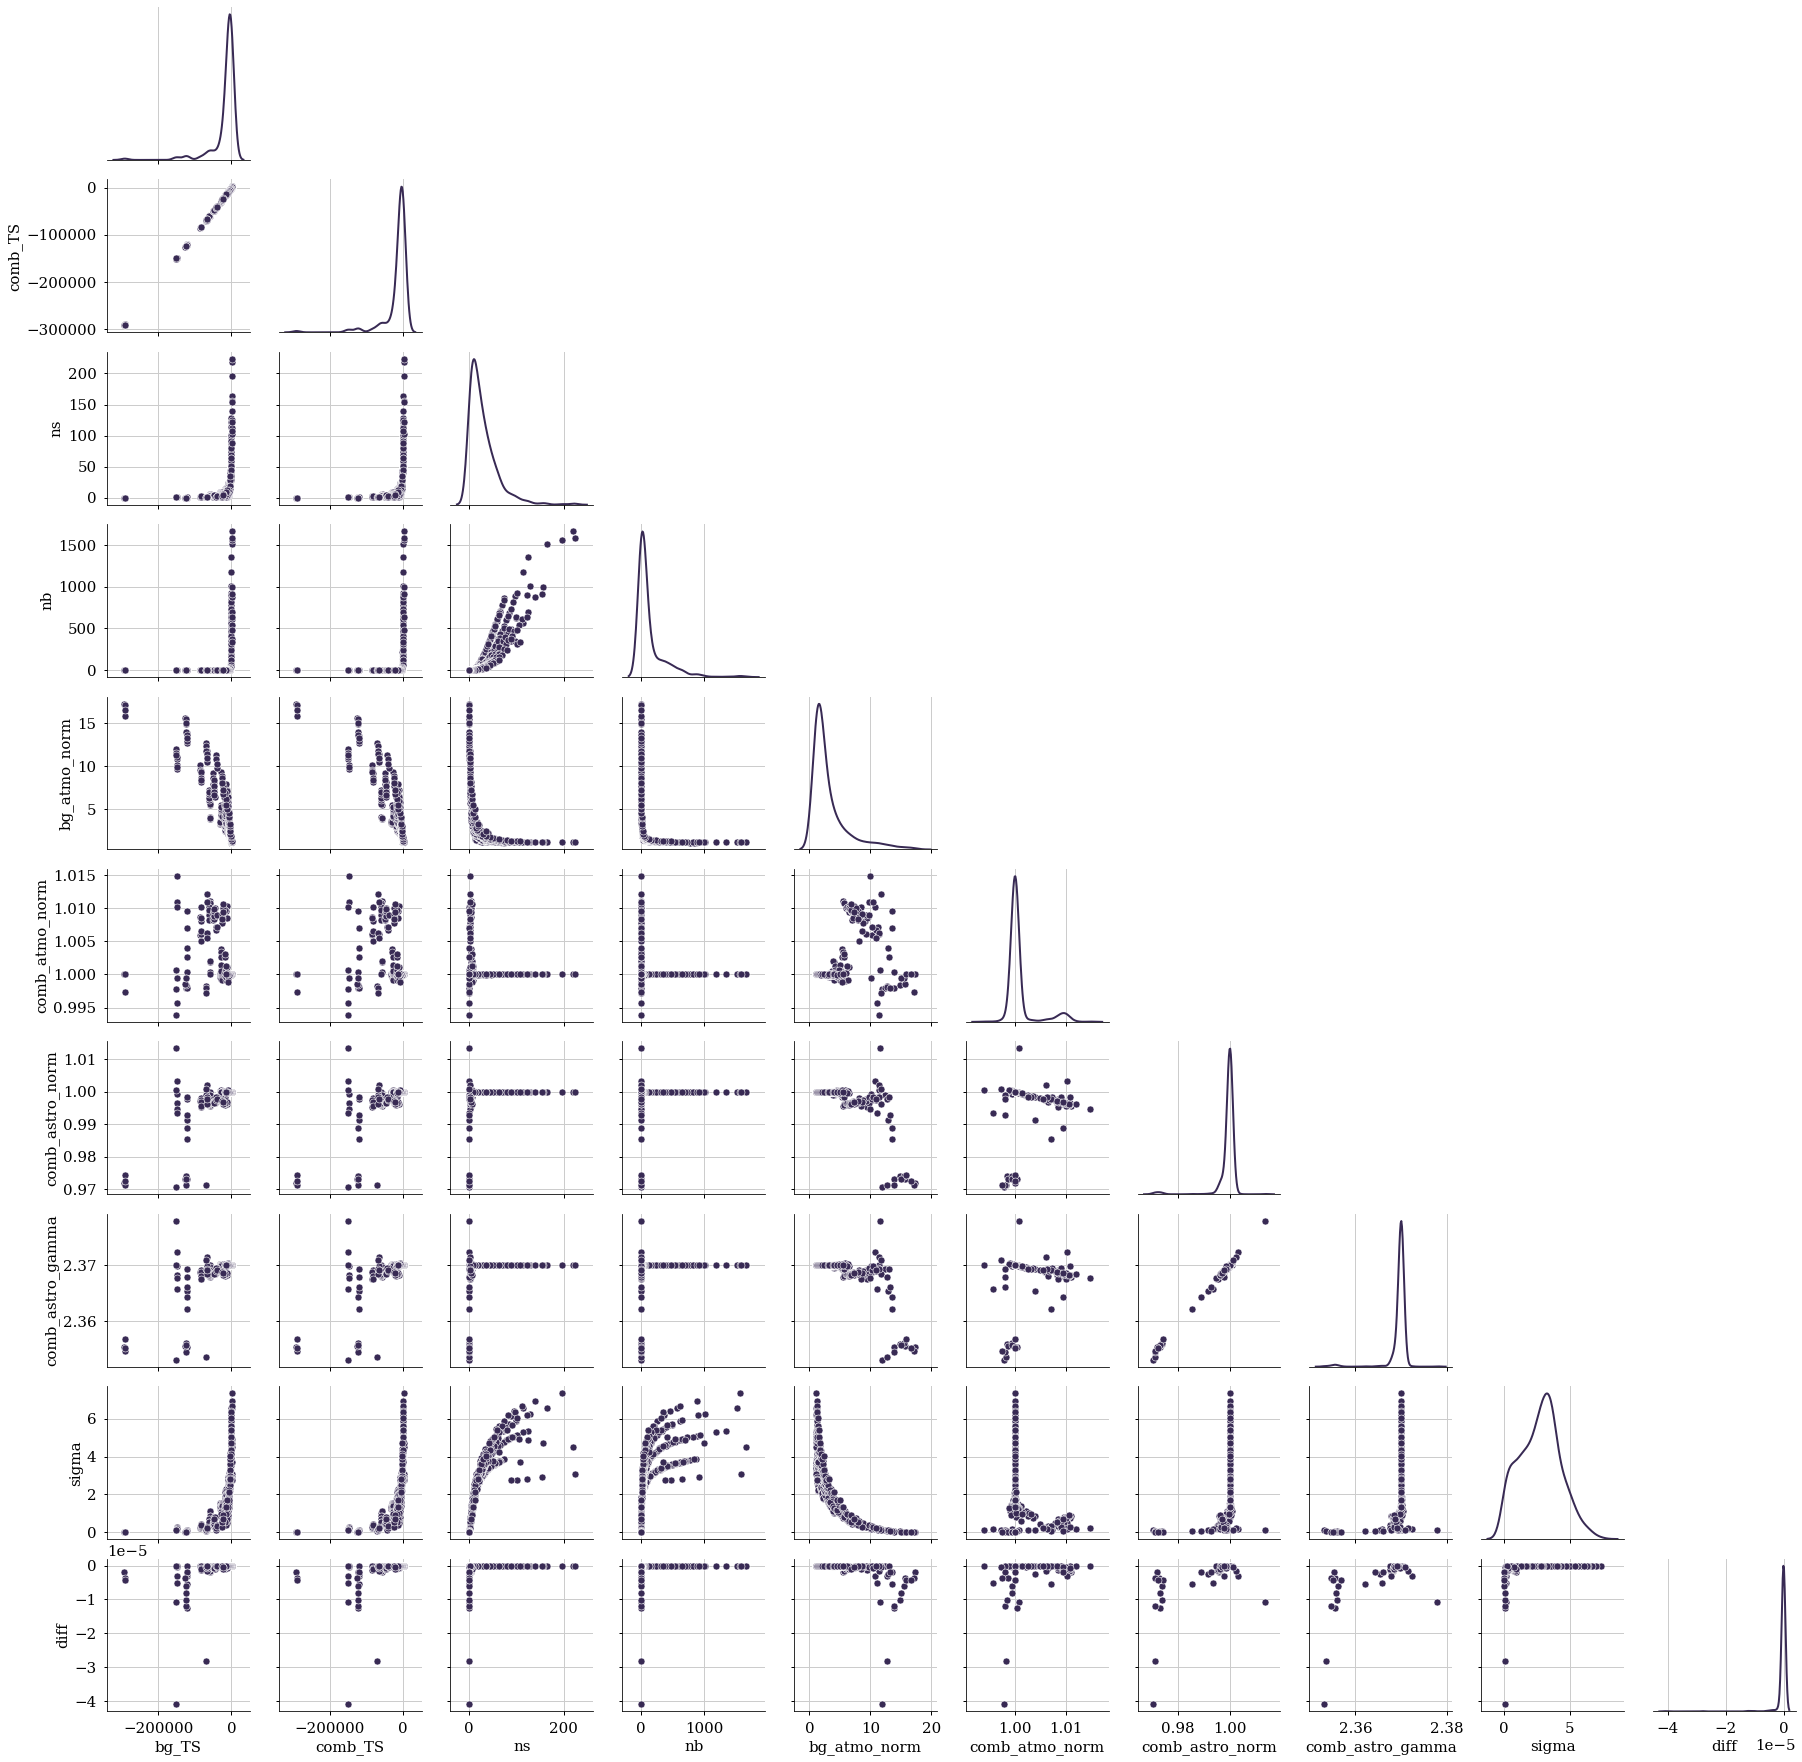

In [123]:
selection = diff_significances_cluster[
    [
        "bg_TS",
        "comb_TS",
        "ns",
        "nb",
        "bg_atmo_norm",
        "comb_atmo_norm",
        "comb_astro_norm",
        "comb_astro_gamma",
        "sigma",
    ]
]
selection["diff"] = diff_significances_cluster.check_TS - diff_significances_cluster.comb_TS

g = sns.PairGrid(selection, diag_sharey=False, corner=True)
g.map_lower(sns.scatterplot)
g.map_diag(sns.kdeplot)

## fitting

In [20]:
c_names = np.asarray(aeffs.index.names)
mask = aeffs.index.get_level_values("spacing") >= 50


for full_det in [False, True]:
    diff_significances = []
    for config, aeff in aeffs.loc[mask].iterrows():
        if full_det:
            aeff *= 7 # full detector
        tmp = {key:val for key, val in zip(c_names, config)}
        aeff_test = aeff["equatorial"]
        reso_test = resolution_df.loc["Full pessimistic cluster", config[-1], 16]

        aeff_factor = (
            (aeff_test * sindec_width).T * ewidth * 2*np.pi * LIVETIME
        )
        k_s = astro_flux(
            "powerlaw",
            aeff_factor,
            emids,
            E_NORM,
            GAMMA_ASTRO,
            1,
            phi_0=PHI_ASTRO,
            normed_kvals=reso_test.energy_res,
        )

        k_b = atmo_background(
            aeff_factor,
            spl_vals,
            normed_kvals=reso_test.energy_res,
        )

        mu_base = np.copy(aeff_factor)
        k_i = k_s + k_b

        tmp["nb"] = np.sum(k_b)
        tmp["ns"] = np.sum(k_s)
        
        # fix signal contribution to 0
        fit_config = dict(
            mu_b_base=mu_base,
            mu_s_base=mu_base,
            k_i=k_i,
            e_0=E_NORM,
            phi_0=PHI_ASTRO,
            shape="powerlaw",
            normed_kvals=reso_test.energy_res,
        )
        local_llh = lambda x: ps_llh_2d_composite((x[0], 3, 0), **fit_config)
        global_llh = lambda x: ps_llh_2d_composite(x, **fit_config)
        out_bckg = fmin_l_bfgs_b(
            local_llh,
            x0=(1.1,),
            bounds=[(1E-3, 1E2)],
            approx_grad=True,
        )
        tmp["bg_atmo_norm"] = out_bckg[0][0]

        out_comp = fmin_l_bfgs_b(
            global_llh,
            x0=(1.0, 2.3, 1.0),
            bounds=[(1E-3, 1E2), (1.5, 3.5), (1E-3, 1E2)],
            approx_grad=True,
            factr=10
        )
        tmp["status"] = out_comp[2]['warnflag']
        tmp["comb_atmo_norm"] = out_comp[0][0]
        tmp["comb_astro_gamma"] = out_comp[0][1]
        tmp["comb_astro_norm"] = out_comp[0][2]
        tmp["-2DLLH"] =  out_bckg[1] - out_comp[1]
        tmp["bg_TS"] =  out_bckg[1]
        tmp["comb_TS"] =  out_comp[1]
        tmp["check_TS"] = global_llh((1, GAMMA_ASTRO, 1))

        pval = chi2.sf(out_bckg[1] - out_comp[1], 2)
        significance = erfinv(1 - pval) * np.sqrt(2)
        tmp["pval"] = pval
        tmp["sigma"] = significance
        tmp["check_sigma"] = erfinv(1 - chi2.sf(out_bckg[1] - tmp["check_TS"], 2)) * np.sqrt(2)
        diff_significances.append(tmp)

    diff_significances = pd.DataFrame(diff_significances)
    diff_significances["comb_threshold"] = np.asarray(
        diff_significances.hit_threshold
        + diff_significances.module_threshold * 10,
        dtype=int,
    )

    diff_significances["sigma_cut"] = 7
    diff_significances.loc[
        diff_significances["sigma"] <= 7, "sigma_cut"
    ] = diff_significances.loc[diff_significances["sigma"] <= 7, "sigma"]
    add = "full" if full_det else "cluster"
    pd.to_pickle(diff_significances, f"../resources/casc_diffuse_significance_{add}.pckl")

## plotting

In [21]:
diff_significances_full = pd.read_pickle("../resources/casc_diffuse_significance_full.pckl")
diff_significances_cluster = pd.read_pickle("../resources/casc_diffuse_significance_cluster.pckl")

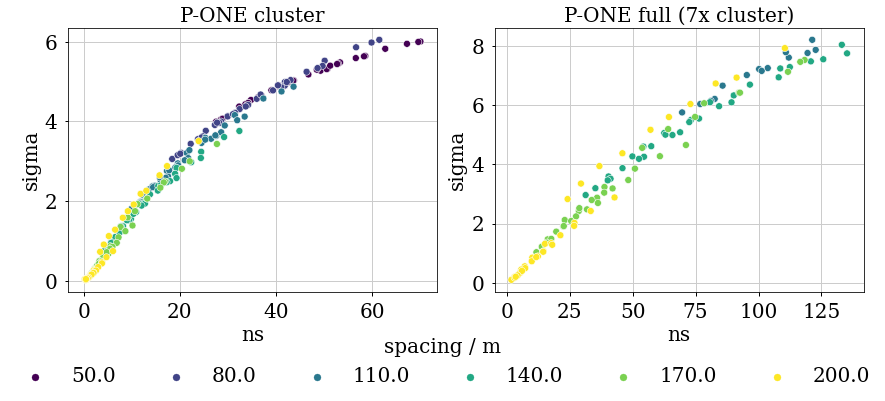

In [22]:
f, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 5))
ax = sns.scatterplot(
    data=diff_significances_cluster.loc[
        (diff_significances_cluster.hit_threshold >= 3)
        & (diff_significances_cluster.module_threshold >= 3)
    ],
    x="ns",
    y="sigma",
    hue="spacing",
    palette="viridis",
    ax=ax1,
)
ax.set_title("P-ONE cluster")
legend = f.legend(
    ncol=6,
    loc="upper center",
    bbox_to_anchor=(0.5, 0.1),
    title="spacing / m",
    frameon=False,
)
legend.get_title().set_fontsize(20)
ax.legend([], frameon=False)
ax = sns.scatterplot(
    data=diff_significances_full.loc[
        (diff_significances_full.hit_threshold >= 3)
        & (diff_significances_full.module_threshold >= 3)
    ],
    x="ns",
    y="sigma",
    hue="spacing",
    palette="viridis",
    ax=ax2,
)
ax.set_title("P-ONE full (7x cluster)")
ax.legend([], frameon=False)

plt.tight_layout()


In [24]:
selection = diff_significances_cluster.loc[(diff_significances_cluster.hit_threshold >= 3) & (diff_significances_cluster.module_threshold >= 3)]

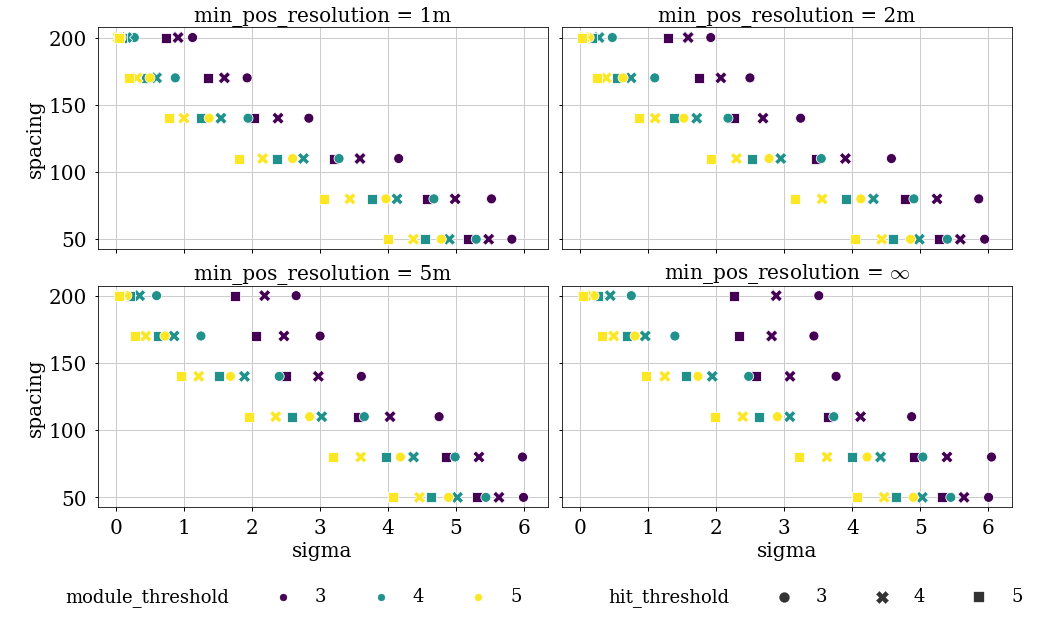

In [25]:
f, axes = plt.subplots(figsize=(14, 8), ncols=2, nrows=2, sharex=True, sharey=True)
ncols = len(selection.module_threshold.unique())

condition = [
    ("min_pos_resolution = 1m", selection.min_pos_resolution == 1),
    ("min_pos_resolution = 2m", selection.min_pos_resolution == 2),
    ("min_pos_resolution = 5m", selection.min_pos_resolution == 5),
    (r"min_pos_resolution = $\infty$", selection.min_pos_resolution.isna()),
]


for ii, ax in enumerate(axes.flatten()):

    ax = sns.scatterplot(
        data=selection.loc[condition[ii][1]],
        x="sigma",
        y="spacing",
        hue="module_threshold",
        style="hit_threshold",
        size="hit_threshold",
        sizes=(100, 200),
        palette="viridis",
        ax=ax,
    )
    #ax.set_xscale("log")
    ax.set_title(condition[ii][0])

    if ii==0:
        f.legend(
        ncol=8, loc="upper center", bbox_to_anchor=(0.5, 0.0), frameon=False, fontsize=18
    )
    ax.legend([], frameon=False)


f.tight_layout()
f.savefig("../plots/cascades_diff_significances.png")


In [23]:
diff_significances

,hit_threshold,module_threshold,min_pos_resolution,spacing,nb,ns,out_bg,out_sig,-2DLLH,pval,sigma,comb_threshold,sigma_cut
0,1,1,NaN,50.0,3.121016,2.806785,[1.8993999526882914],"[1.0000405260721694, 3.1999839632388896, 0.999...",7.246142,0.026701,2.215868,11,2.215868
1,1,1,1.0,50.0,2.296883,2.117451,[1.9218432492429374],"[1.0000805725934276, 3.200130303224324, 1.0001...",5.778695,0.055612,1.914060,11,1.914060
2,1,1,2.0,50.0,2.799349,2.535781,[1.9058659329100696],"[1.000084052065594, 3.200058407713273, 1.00004...",6.660617,0.035782,2.099395,11,2.099395
3,1,1,5.0,50.0,3.041746,2.742354,[1.9015695733996734],"[1.000029032166243, 3.2000689789569794, 1.0000...",7.120860,0.028427,2.191348,11,2.191348
4,2,1,NaN,50.0,2.561056,2.334045,[1.9113012500227775],"[1.0000924714539712, 3.199930204265275, 0.9999...",6.214917,0.044714,2.007331,12,2.007331
...,...,...,...,...,...,...,...,...,...,...,...,...,...
595,4,5,5.0,200.0,0.000046,0.000221,[1.2],"[1.2, 3.3160861904143797, 1.0946379365285375]",0.001839,0.999081,0.001152,54,0.001152
596,5,5,NaN,200.0,0.000031,0.000151,[1.2],"[1.2, 3.286404560227237, 1.2]",0.001295,0.999352,0.000812,55,0.000812
597,5,5,1.0,200.0,0.000012,0.000063,[1.2],"[1.2, 3.312204763685603, 1.2]",0.000530,0.999735,0.000332,55,0.000332
598,5,5,2.0,200.0,0.000021,0.000107,[1.2],"[1.2, 3.298778114820413, 1.2]",0.000912,0.999544,0.000571,55,0.000571
